<a href="https://colab.research.google.com/github/balados85/deep-learning-brain-mri-classification/blob/main/custom_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ray[tune]


In [83]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import csv
import numpy as np
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

In [84]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path) # Converts to tensor
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return sample

In [85]:
label_id = {0:'glioma', 1:'meningioma', 2:'pituitary'}
with open('drive/MyDrive/mri_images/train/train.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_location', 'label']) # Write header
    for dirs in listdir("drive/MyDrive/mri_images/train"):
#         print(dirs)
        if(dirs.endswith(".csv") or dirs.endswith(".DS_Store")):
            continue
        for f in listdir(join("drive/MyDrive/mri_images/train", dirs)):
            if(join("drive/MyDrive/mri_images/train", dirs, f).endswith(".csv") or f == ".DS_Store"):
                continue
            elif isfile(join("drive/MyDrive/mri_images/train", dirs, f)):
                writer.writerow([join(dirs, f), dirs])

In [86]:
with open('drive/MyDrive/mri_images/test/test.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_location', 'label']) # Write header
    for dirs in listdir("drive/MyDrive/mri_images/test"):
#         print(dirs)
        if(dirs.endswith(".csv") or dirs.endswith(".DS_Store")):
            continue
        for f in listdir(join("drive/MyDrive/mri_images/test", dirs)):
            if(join("drive/MyDrive/mri_images/test", dirs, f).endswith(".csv") or f == ".DS_Store"):
                continue
            elif isfile(join("drive/MyDrive/mri_images/test", dirs, f)):
                writer.writerow([join(dirs, f), dirs])

In [87]:
# Might be a good idea to make the image in grayscale and make them smaller (check here: https://pytorch.org/vision/stable/transforms.html)
training_data = CustomImageDataset('drive/MyDrive/mri_images/train/train.csv', 'drive/MyDrive/mri_images/train')

testing_data = CustomImageDataset('drive/MyDrive/mri_images/test/test.csv', 'drive/MyDrive/mri_images/test')

print(len(training_data))
print(len(testing_data))

train_sample = training_data[0]
test_sample = testing_data[0]
print(type(train_sample["image"]))
print(train_sample["image"].shape)

print(type(test_sample["image"]))
print(test_sample["image"].shape)

# print(edd_train[0])

2552
569
<class 'torch.Tensor'>
torch.Size([1, 512, 512])
<class 'torch.Tensor'>
torch.Size([1, 512, 512])


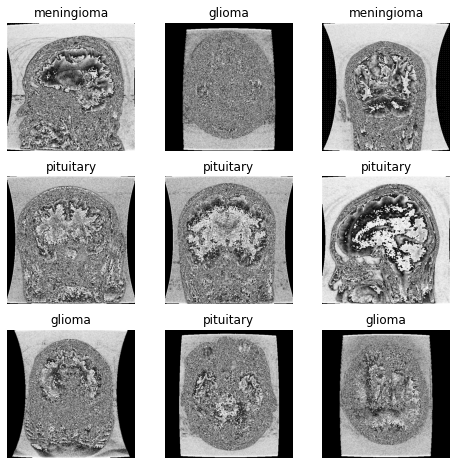

In [88]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # Get rnd_id
    sample = training_data[sample_idx] # index dataset (gets you the img and label - index)
    img, label = sample["image"], sample["label"]
    figure.add_subplot(rows, cols, i)
    plt.title(label_id[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") # if the image is grayscale
   # plt.imshow(img.permute(1,2,0)) # put channel as the last dimension
plt.show()

In [89]:
#train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=4)
#test_dataloader = DataLoader(testing_data, batch_size=64, shuffle=True, num_workers=4)
def load_data(data_dir="drive/MyDrive/mri_images/"):
    data_transforms = {
      'train': transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.RandomRotation(5, fill =(5)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'test': transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train','test']}
        
    return image_datasets

#dataloaders = {x: torch.utils.data.DataLoader(load_data(data_dir)[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train','test']}

#dataset_sizes = {x: len(load_data(data_dir)[x]) for x in ['train','test']}

#class_names = load_data(data_dir)['test'].classes

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")





/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


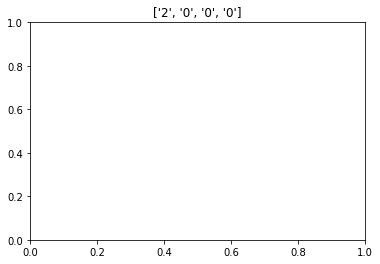

In [90]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [95]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 224 * 224)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [96]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    
    trainset = load_data(data_dir)['train'] 
    testset = load_data(data_dir)['test']

    #traindata = trainloads['train']
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [97]:
def test_accuracy(net, device="cpu"):
    testloader = {x: torch.utils.data.DataLoader(load_data(data_dir)[x], batch_size=int(4), shuffle=True, num_workers=2) for x in ['test']}

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [98]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    data_dir = os.path.abspath("./drive/MyDrive/mri_images")
    load_data(data_dir)
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=0)

2021-05-28 15:20:46,454	WARNING experiment.py:294 -- No name detected on trainable. Using DEFAULT.
2021-05-28 15:20:46,455	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Memory usage on this node: 1.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/0 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-05-28_15-20-46
Number of trials: 10/10 (10 PENDING)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_46a7a_00000 | PENDING  |       |            2 |   64 |  256 | 0.000171124 |
| DEFAULT_46a7a_00001 | PENDING  |       |            4 |   64 |   32 | 0.0106607   |
| DEFAULT_46a7a_00002 | PENDING  |       |            8 |   32 |  256 | 0.01177     |
| DEFAULT_46a7a_00003 | PENDING  |       |           16 |   32 |    8 | 0.000192865 |
| DEFAULT_46a7a_00004 | PENDING  |       |     

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=14211) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessiv

Result for DEFAULT_46a7a_00000:
  {}
  


(pid=14212) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=14212)   cpuset_checked))


== Status ==
Memory usage on this node: 1.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-05-28_15-20-46
Number of trials: 10/10 (1 ERROR, 8 PENDING, 1 RUNNING)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_46a7a_00001 | RUNNING  |       |            4 |   64 |   32 | 0.0106607   |
| DEFAULT_46a7a_00002 | PENDING  |       |            8 |   32 |  256 | 0.01177     |
| DEFAULT_46a7a_00003 | PENDING  |       |           16 |   32 |    8 | 0.000192865 |
| DEFAULT_46a7a_00004 | PENDING  |       |            8 |   64 |  128 | 0.0207939   |
| DEFAULT_46a7a_00005 | PE

(pid=14212) 2021-05-28 15:20:52,402	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=14212) Traceback (most recent call last):
(pid=14212)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 248, in run
(pid=14212)     self._entrypoint()
(pid=14212)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=14212)     self._status_reporter.get_checkpoint())
(pid=14212)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 580, in _trainable_func
(pid=14212)     output = fn()
(pid=14212)   File "<ipython-input-96-db2fd70f4394>", line 51, in train_cifar
(pid=14212)   File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 889, in _call_impl
(pid=14212)     result = self.forward(*input, **kwargs)
(pid=14212)   File "<ipython-input-95-1ea2a718dd56>", line 14, in forward
(pid=14212) RuntimeError: shape '[-1, 802816]' is invalid for input of size 179

Result for DEFAULT_46a7a_00001:
  {}
  


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=14335) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=14335)   cpuset_checked))
(pid=14335) 2021-05-28 15:20:56,120	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=14335) Traceback (most recent call last):
(pid=14335)   File "/usr/local/

Result for DEFAULT_46a7a_00002:
  {}
  
== Status ==
Memory usage on this node: 1.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-05-28_15-20-46
Number of trials: 10/10 (3 ERROR, 6 PENDING, 1 RUNNING)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_46a7a_00003 | RUNNING  |       |           16 |   32 |    8 | 0.000192865 |
| DEFAULT_46a7a_00004 | PENDING  |       |            8 |   64 |  128 | 0.0207939   |
| DEFAULT_46a7a_00005 | PENDING  |       |            4 |   32 |    4 | 0.00011117  |
| DEFAULT_46a7a_00006 | PENDING  |       |            4 |   16 |   64 | 

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=14401) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=14401)   cpuset_checked))
(pid=14401) 2021-05-28 15:21:00,758	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=14401) Traceback (most recent call last):
(pid=14401)   File "/usr/local/

Result for DEFAULT_46a7a_00003:
  {}
  


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=14463) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=14463)   cpuset_checked))
(pid=14463) 2021-05-28 15:21:04,499	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=14463) Traceback (most recent call last):
(pid=14463)   File "/usr/local/

Result for DEFAULT_46a7a_00004:
  {}
  
== Status ==
Memory usage on this node: 1.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/0 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-05-28_15-20-46
Number of trials: 10/10 (5 ERROR, 5 PENDING)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_46a7a_00005 | PENDING  |       |            4 |   32 |    4 | 0.00011117  |
| DEFAULT_46a7a_00006 | PENDING  |       |            4 |   16 |   64 | 0.00921619  |
| DEFAULT_46a7a_00007 | PENDING  |       |           16 |   32 |  256 | 0.00923115  |
| DEFAULT_46a7a_00008 | PENDING  |       |            8 |  128 |   64 | 0.0047745   |

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=14529) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=14529)   cpuset_checked))
2021-05-28 15:21:07,786	ERROR trial_runner.py:732 -- Trial DEFAULT_46a7a_00005: Error processing event.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/di

Result for DEFAULT_46a7a_00005:
  {}
  


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=14591) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=14591)   cpuset_checked))
2021-05-28 15:21:10,607	ERROR trial_runner.py:732 -- Trial DEFAULT_46a7a_00006: Error processing event.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/di

Result for DEFAULT_46a7a_00006:
  {}
  
== Status ==
Memory usage on this node: 1.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/0 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-05-28_15-20-46
Number of trials: 10/10 (7 ERROR, 3 PENDING)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_46a7a_00007 | PENDING  |       |           16 |   32 |  256 | 0.00923115  |
| DEFAULT_46a7a_00008 | PENDING  |       |            8 |  128 |   64 | 0.0047745   |
| DEFAULT_46a7a_00009 | PENDING  |       |           16 |    4 |   16 | 0.000116165 |
| DEFAULT_46a7a_00000 | ERROR    |       |            2 |   64 |  256 | 0.000171124 |

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=14657) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=14657)   cpuset_checked))
(pid=14657) 2021-05-28 15:21:15,036	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=14657) Traceback (most recent call last):
(pid=14657)   File "/usr/local/

Result for DEFAULT_46a7a_00007:
  {}
  


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=14723) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=14723)   cpuset_checked))
2021-05-28 15:21:18,596	ERROR trial_runner.py:732 -- Trial DEFAULT_46a7a_00008: Error processing event.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/di

Result for DEFAULT_46a7a_00008:
  {}
  
== Status ==
Memory usage on this node: 1.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/0 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-05-28_15-20-46
Number of trials: 10/10 (9 ERROR, 1 PENDING)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_46a7a_00009 | PENDING  |       |           16 |    4 |   16 | 0.000116165 |
| DEFAULT_46a7a_00000 | ERROR    |       |            2 |   64 |  256 | 0.000171124 |
| DEFAULT_46a7a_00001 | ERROR    |       |            4 |   64 |   32 | 0.0106607   |
| DEFAULT_46a7a_00002 | ERROR    |       |            8 |   32 |  256 | 0.01177     |

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=14788) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=14788)   cpuset_checked))
(pid=14788) 2021-05-28 15:21:23,288	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=14788) Traceback (most recent call last):
(pid=14788)   File "/usr/local/

Result for DEFAULT_46a7a_00009:
  {}
  
== Status ==
Memory usage on this node: 1.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/0 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-05-28_15-20-46
Number of trials: 10/10 (10 ERROR)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_46a7a_00000 | ERROR    |       |            2 |   64 |  256 | 0.000171124 |
| DEFAULT_46a7a_00001 | ERROR    |       |            4 |   64 |   32 | 0.0106607   |
| DEFAULT_46a7a_00002 | ERROR    |       |            8 |   32 |  256 | 0.01177     |
| DEFAULT_46a7a_00003 | ERROR    |       |           16 |   32 |    8 | 0.000192865 |
| DEFAULT

TuneError: ignored